## Análisis de la etapa de generación de medios

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  

## Armado del dataset

En este paso parsearemos los archivos para obtener estadísticas sobre el tiempo que tarda cada ejecución de una función, sobre la memoria usada, el uso de CPU. Con esto buscamos identificar:
- Qué funciones son las que consumen mayor cantidad de memoria
- Qué funciones son las que tienen un mayor tiempo de procesamiento
- Qué funciones son las que son invocadas una mayor cantidad de veces

Una vez identificados estos puntos de análisis podemos proponer soluciones para mejorar estas estadísticas.

In [108]:
def get_function_name(function_name):
    return function_name[10:].rsplit(".c")[0]

In [109]:
relations = {
    "Py_kgeneration": ['generate', 'fftma2'],
    "generate": ["gasdev"],
    "gasdev": ["ran2"],
    "fftma2": ["covariance", "fourt", "prebuild_gwn"]
}

In [158]:
def get_data(file_name):
    data = []
    row = {}

    with open(file_name) as log_file:
        lines = log_file.readlines()
        for line in lines:
            split_line = line.split()
                
            if "USED" not in split_line and "ELAPSED" not in split_line and "CPU" not in split_line: continue
    
            if "CPU" in split_line:
                idx_cpu = split_line.index("CPU") + 1
                idx_per = idx_cpu + 1
                row["CPU_{}".format(split_line[idx_cpu].rsplit(':')[0])] = float(split_line[idx_per].rsplit("%")[0])
                continue
                
                
            idx_used_mem = split_line.index("USED") + 4
            idx_elapsed = split_line.index("ELAPSED") + 2
            
            function_name = get_function_name(split_line[2])
                        
            used_virtual_mem = float(split_line[idx_used_mem])
            elapsed = float(split_line[idx_elapsed].rsplit(",")[0])

            row["function"] = function_name
            row["memory"] = used_virtual_mem 
            row["time"] = elapsed
            print(row)
            data.append(row)
            row = {}
            
    return data

In [156]:
def create_df(file_name):
    data = get_data(file_name)
    df = pd.DataFrame(data)
    return df.groupby(['function']).agg({'time': ['min', 'max', 'mean', 'sum', 'count'], 'memory': ['min', 'max', 'median'], 'CPU_0': ['mean'], 'CPU_1': ['mean'], 'CPU_2': ['mean'], 'CPU_3': ['mean'], 'CPU_4': ['mean'], 'CPU_5': ['mean'], 'CPU_6': ['mean'], 'CPU_7': ['mean']})

In [150]:
def analyze(file_name):
    df_grouped = create_df(file_name)
    return df_grouped.sort_values(by=('time', 'sum'), ascending=False)                

In [151]:
def plot_pie(df, function):
    plt.figure(dpi=125, figsize=(6, 6))
    labels = relations[function].copy()
    total = df.loc[function][('time', 'sum')]
    sizes = []
    explode = []

    rest = total

    for func in labels:
        func_duration = df.loc[func][('time', 'sum')]
        rest -= func_duration
        value = func_duration/ total
        sizes.append(value)
        explode.append(0 if value > 0.01 else 0.1)

    labels.append("other")
    sizes.append(rest/total)
    sizes = np.array(sizes)
    porcent = 100.*sizes/sizes.sum()
    explode.append(0 if rest/total > 0.01 else 0.1)

    plt.title(function)

    patches, texts = plt.pie(sizes, startangle=90, radius=1.2)
    labels_formated = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]

    sort_legend = True
    if sort_legend:
        patches, labels_formated, dummy =  zip(*sorted(zip(patches, labels_formated, sizes),
                                              key=lambda x: x[2],
                                              reverse=True))

    plt.legend(patches, labels_formated, loc='upper left', bbox_to_anchor=(-0.1, 1.),
               fontsize=8)
    
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

def plot_analysis(df):
    for func in relations.keys():
        plot_pie(df, func)
    

## N = 8

In [157]:
df = analyze('log_8-aa')


df

{'function': 'generate', 'time': 0.011741, 'memory': 0.5, 'CPU_2': 0.1, 'CPU_3': 100.1, 'CPU_0': 44.544444, 'CPU_1': 50.1, 'CPU_6': 0.1, 'CPU_7': 100.1, 'CPU_4': 0.1, 'CPU_5': 0.1}
{'function': 'Py_kgeneration', 'time': 0.018899, 'memory': 0.5, 'CPU_2': 0.1, 'CPU_3': 50.1, 'CPU_0': 41.276471, 'CPU_1': 33.433333, 'CPU_6': 0.1, 'CPU_7': 100.1, 'CPU_4': 0.1, 'CPU_5': 0.1}


CPU_1      time                                     CPU_2  \
                     mean       min       max      mean       sum count  mean   
function                                                                        
Py_kgeneration  33.433333  0.018899  0.018899  0.018899  0.018899     1   0.1   
generate        50.100000  0.011741  0.011741  0.011741  0.011741     1   0.1   

                CPU_3      CPU_0 memory             CPU_6  CPU_7 CPU_4 CPU_5  
                 mean       mean    min  max median  mean   mean  mean  mean  
function                                                                      
Py_kgeneration   50.1  41.276471    0.5  0.5    0.5   0.1  100.1   0.1   0.1  
generate        100.1  44.544444    0.5  0.5    0.5   0.1  100.1   0.1   0.1

/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


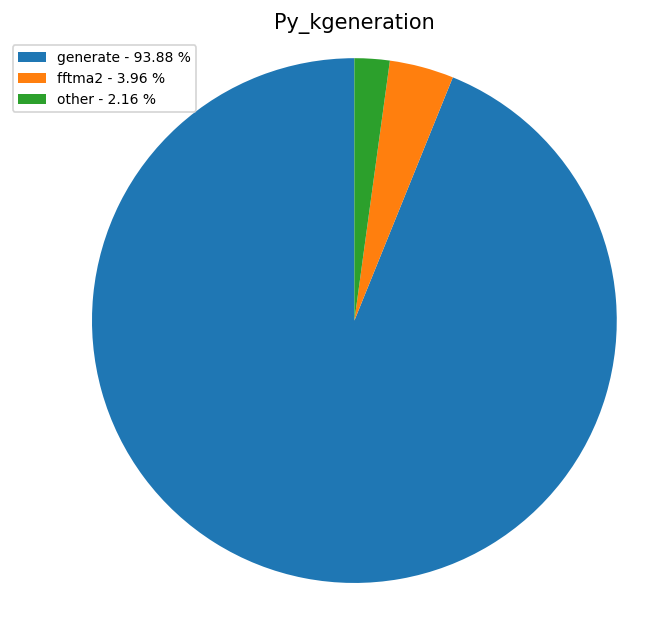

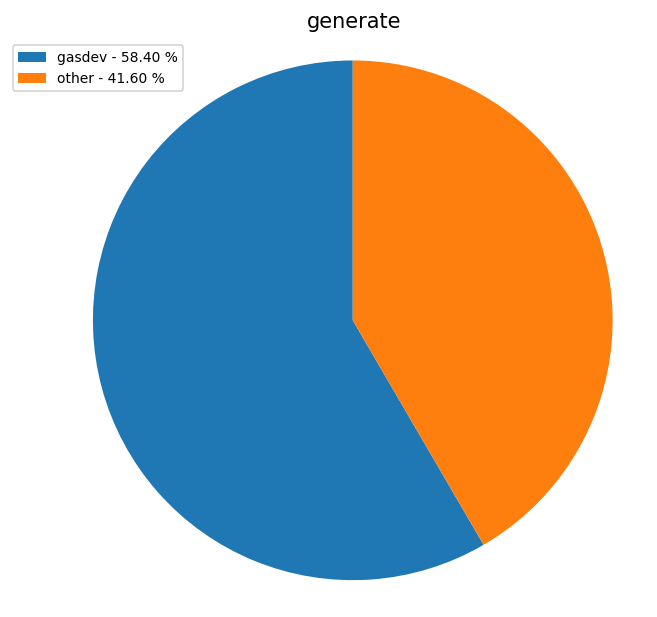

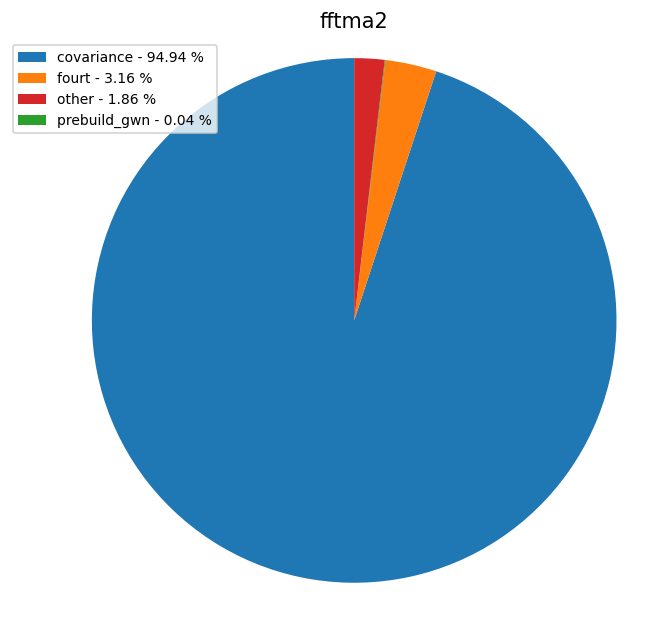

In [10]:
plot_analysis(df)

## N = 16

In [25]:
df = analyze('log_16-aa')

12945


In [27]:
df

time                                         memory       \
                     min       max          mean       sum count    min  max   
function                                                                       
Py_kgeneration  0.215496  0.215496  2.154960e-01  0.215496     1   -3.0 -3.0   
generate        0.189414  0.189414  1.894140e-01  0.189414     1   -3.0 -3.0   
gasdev          0.000000  0.003814  2.688184e-05  0.110108  4096   -4.0  0.2   
fftma2          0.023857  0.023857  2.385700e-02  0.023857     1    0.0  0.0   
covariance      0.022837  0.022837  2.283700e-02  0.022837     1    0.0  0.0   
ran2            0.000000  0.000007  5.074032e-07  0.002673  5268    0.0  0.2   
cov_value       0.000000  0.000018  5.033670e-07  0.001794  3564    0.0  0.0   
fourt           0.000233  0.000341  2.863333e-04  0.000859     3    0.0  0.0   
build_real      0.000054  0.000054  5.400000e-05  0.000054     1    0.0  0.0   
cgrid           0.000024  0.000024  2.400000e-05  0.000024     1    0.0  0.0   
prebuild_gwn    0.000018  0.000018  1.800000e-05  0.000018     1    0.0  0.0   
length          0.000004  0.000005  4.333333e-06  0.000013     3    0.0  0.0   
clean_real      0.000003  0.000003  3.000000e-06  0.000003     1    0.0  0.0   
maxfactor       0.000000  0.000001  6.666667e-07  0.000002     3    0.0  0.0   

                       
               median  
function               
Py_kgeneration   -3.0  
generate         -3.0  
gasdev            0.0  
fftma2            0.0  
covariance        0.0  
ran2              0.0  
cov_value         0.0  
fourt             0.0  
build_real        0.0  
cgrid             0.0  
prebuild_gwn      0.0  
length            0.0  
clean_real        0.0  
maxfactor         0.0

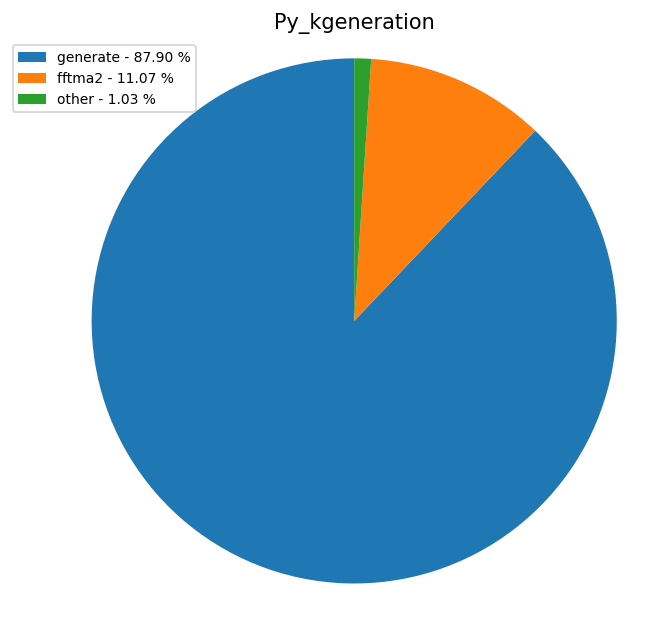

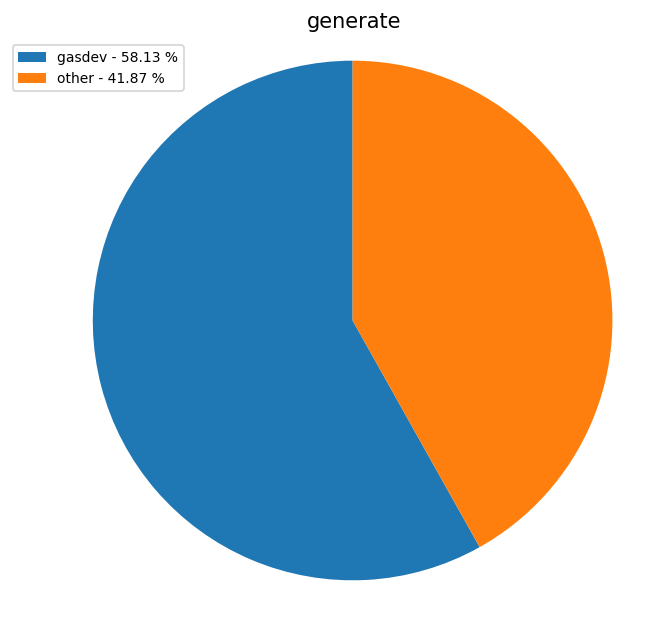

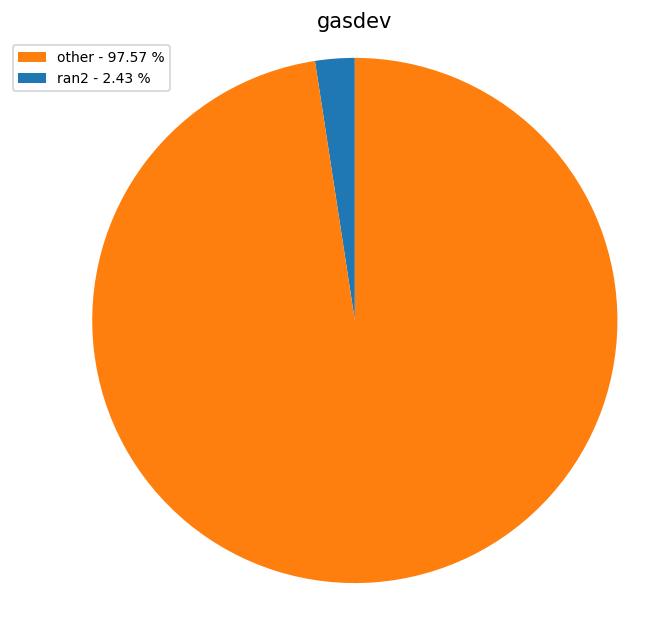

/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


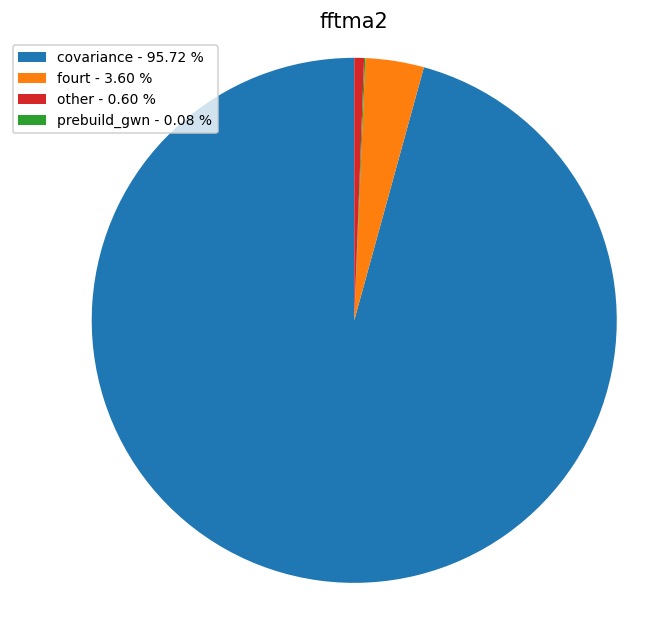

In [26]:
plot_analysis(df)

## N = 32

In [28]:
df = analyze('log_32-aa')

98963


In [29]:
df

time                                          memory       \
                     min       max          mean       sum  count    min  max   
function                                                                        
Py_kgeneration  0.788862  0.788862  7.888620e-01  0.788862      1    9.8  9.8   
generate        0.592958  0.592958  5.929580e-01  0.592958      1    3.6  3.6   
gasdev          0.000000  0.002927  1.034552e-05  0.339002  32768   -0.8  0.4   
fftma2          0.193739  0.193739  1.937390e-01  0.193739      1    6.2  6.2   
covariance      0.184742  0.184742  1.847420e-01  0.184742      1    5.0  5.0   
ran2            0.000000  0.000029  4.300876e-07  0.017871  41552   -0.2  0.2   
cov_value       0.000000  0.000022  6.040042e-07  0.014873  24624    0.0  0.4   
fourt           0.002029  0.003641  2.702000e-03  0.008106      3    0.0  0.2   
build_real      0.000441  0.000441  4.410000e-04  0.000441      1    0.5  0.5   
prebuild_gwn    0.000132  0.000132  1.320000e-04  0.000132      1    0.2  0.2   
clean_real      0.000076  0.000076  7.600000e-05  0.000076      1    0.0  0.0   
cgrid           0.000049  0.000049  4.900000e-05  0.000049      1    0.0  0.0   
length          0.000006  0.000015  1.066667e-05  0.000032      3    0.0  0.0   
maxfactor       0.000000  0.000001  6.000000e-07  0.000003      5    0.0  0.0   

                       
               median  
function               
Py_kgeneration    9.8  
generate          3.6  
gasdev            0.0  
fftma2            6.2  
covariance        5.0  
ran2              0.0  
cov_value         0.0  
fourt             0.2  
build_real        0.5  
prebuild_gwn      0.2  
clean_real        0.0  
cgrid             0.0  
length            0.0  
maxfactor         0.0

/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


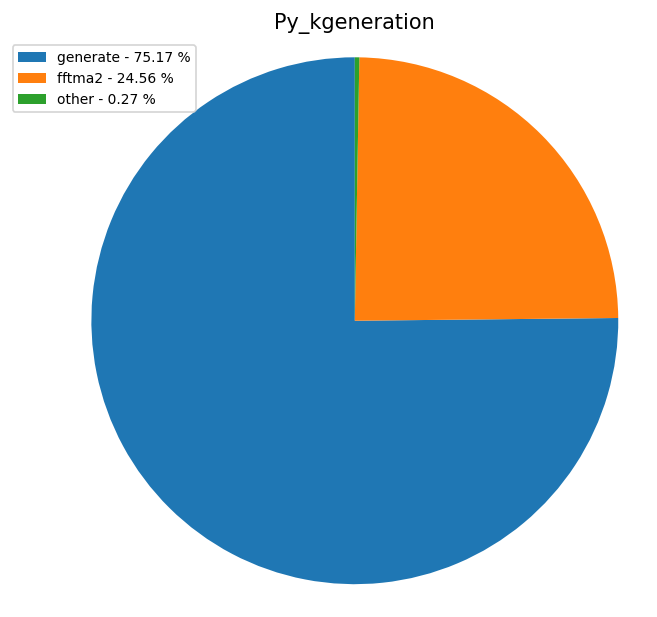

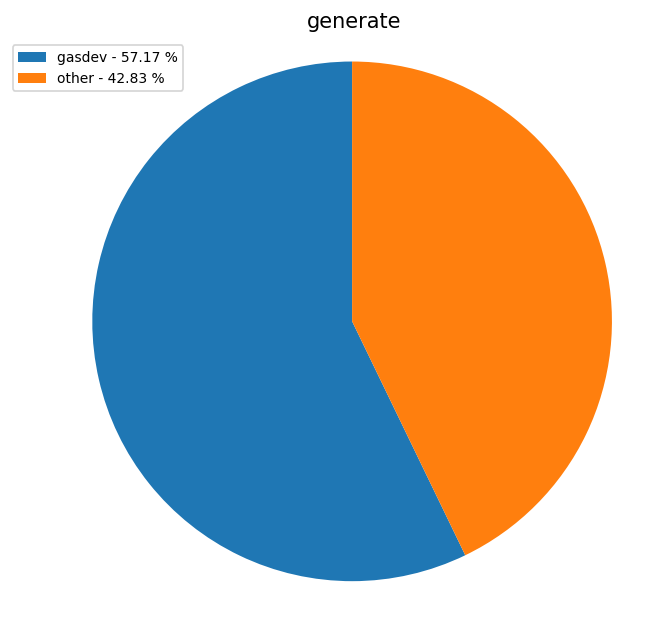

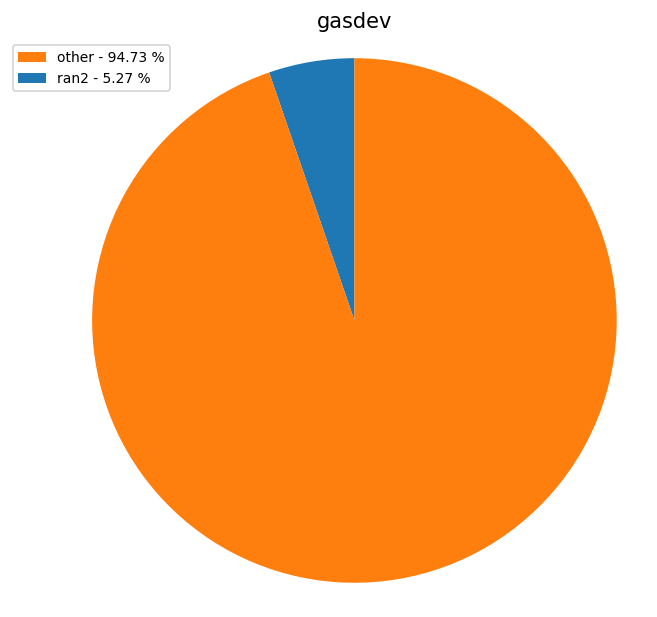

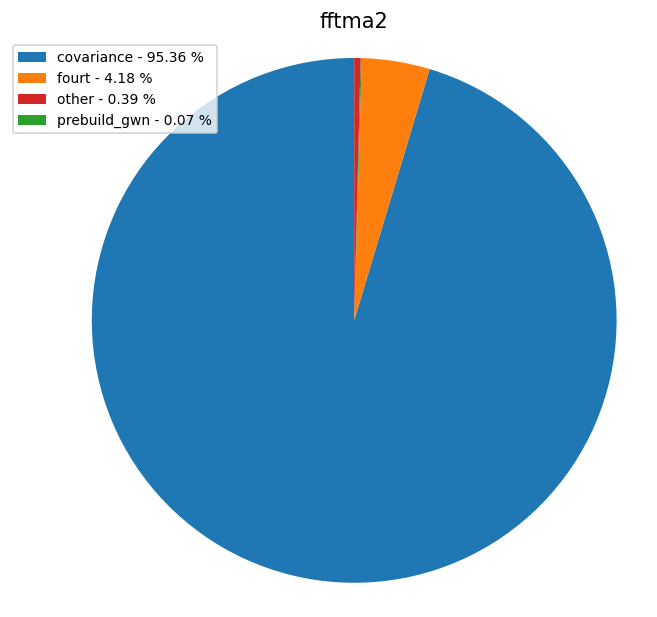

In [30]:
plot_analysis(df)

## N = 64

In [31]:
df = analyze('log_64-aa')

752428


In [32]:
df

time                                           memory  \
                     min       max          mean       sum   count    min   
function                                                                    
Py_kgeneration  4.949173  4.949173  4.949173e+00  4.949173       1  120.8   
generate        3.664372  3.664372  3.664372e+00  3.664372       1   77.4   
gasdev          0.000000  0.000135  8.024132e-06  2.103478  262144   -1.8   
fftma2          1.284480  1.284480  1.284480e+00  1.284480       1   45.5   
covariance      1.196127  1.196127  1.196127e+00  1.196127       1   39.1   
ran2            0.000000  0.000056  3.717559e-07  0.123962  333450   -0.2   
cov_value       0.000000  0.000029  5.676589e-07  0.089018  156816   -0.2   
fourt           0.021057  0.040839  2.775567e-02  0.083267       3    0.0   
build_real      0.002964  0.002964  2.964000e-03  0.002964       1    0.0   
prebuild_gwn    0.000825  0.000825  8.250000e-04  0.000825       1    2.5   
clean_real      0.000608  0.000608  6.080000e-04  0.000608       1    0.9   
cgrid           0.000055  0.000055  5.500000e-05  0.000055       1    0.0   
length          0.000008  0.000016  1.066667e-05  0.000032       3    0.0   
maxfactor       0.000000  0.000001  5.000000e-07  0.000002       4    0.0   

                              
                  max median  
function                      
Py_kgeneration  120.8  120.8  
generate         77.4   77.4  
gasdev            0.5    0.0  
fftma2           45.5   45.5  
covariance       39.1   39.1  
ran2              0.4    0.0  
cov_value         0.3    0.0  
fourt             3.9    0.5  
build_real        0.0    0.0  
prebuild_gwn      2.5    2.5  
clean_real        0.9    0.9  
cgrid             0.0    0.0  
length            0.0    0.0  
maxfactor         0.0    0.0

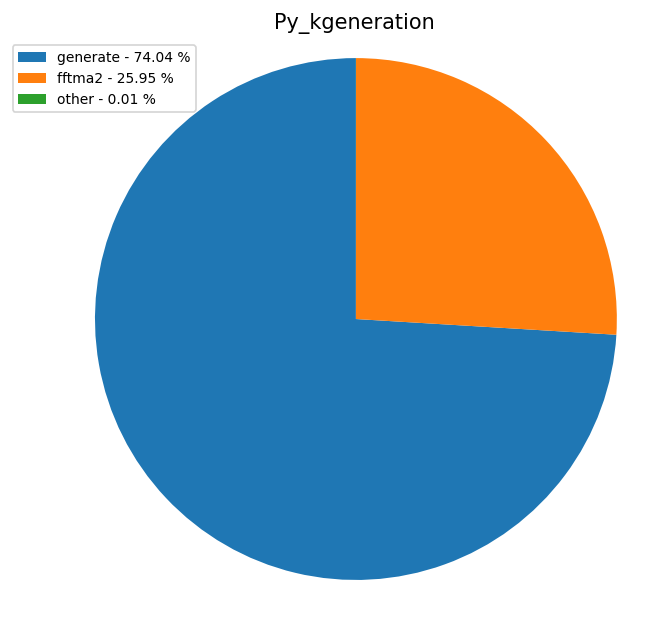

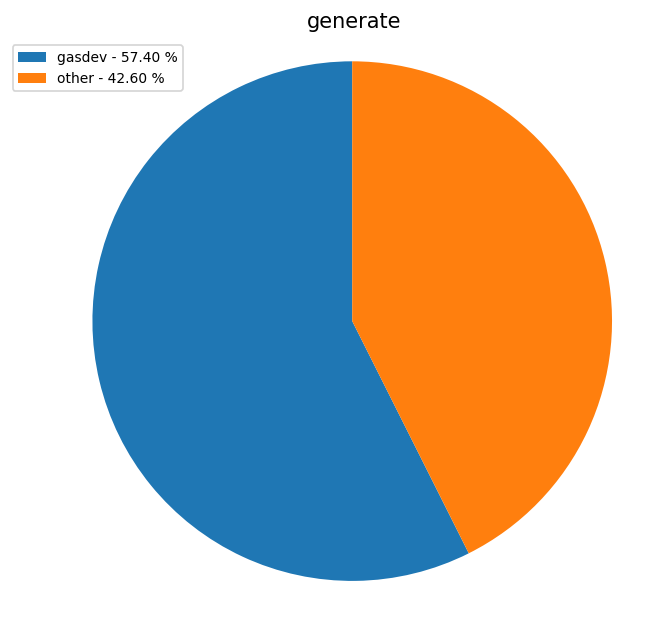

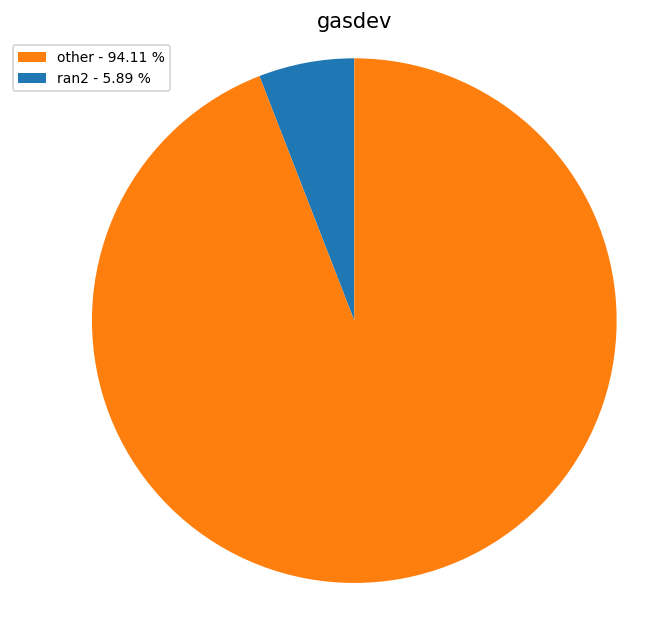

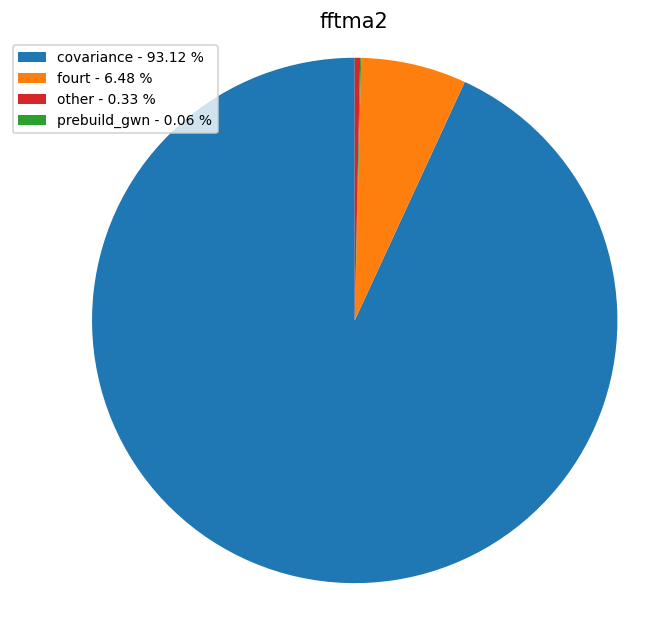

In [33]:
plot_analysis(df)

## N = 128

In [ ]:
df = analyze('log_128-aa')

5897863


In [ ]:
df

In [ ]:
plot_analysis(df)

## N = 256

In [94]:
dfs = []
for i in range(10):
    print("Executing file number {} out of 10".format(i+1))
    df = create_df("log_256_{}.txt".format(i+1))
    dfs.append(df)

Executing file number 1 out of 10
Executing file number 2 out of 10
Executing file number 3 out of 10
Executing file number 4 out of 10
Executing file number 5 out of 10
Executing file number 6 out of 10
Executing file number 7 out of 10
Executing file number 8 out of 10
Executing file number 9 out of 10
Executing file number 10 out of 10


In [95]:
def merge_dfs(dfs):
    functions = ['Py_kgeneration', 'generate', 'fftma2', 'covariance', 'gasdev', 'fourt', 'cov_value', 'ran2', 'build_real', 'prebuild_gwn', 'clean_real', 'cgrid', 'length', 'maxfactor']
    df_final = pd.concat(dfs, join='inner').sort_values(by=('time', 'sum'), ascending=False) 

    memory_min, memory_max, memory_median = [], [], []
    time_min, time_max, time_mean, time_sum, time_count = [], [], [], [], []

    for function in functions:
        memory_min.append(df_final.loc[function, ('memory', 'min')].min())
        time_min.append(df_final.loc[function, ('time', 'min')].min())
        memory_max.append(df_final.loc[function, ('memory', 'max')].max())
        time_max.append(df_final.loc[function, ('time', 'max')].max())
        time_mean.append(df_final.loc[function, ('time', 'mean')].mean())
        time_sum.append(df_final.loc[function, ('time', 'sum')].sum())
        time_count.append(df_final.loc[function, ('time', 'count')].sum())
        try:
            memory_median.append(df_final.loc[function, ('memory', 'median')].median())
        except:
            memory_median.append(df_final.loc[function, ('memory', 'median')])
        
    df = pd.DataFrame({('memory', 'min'): memory_min, ('memory', 'max'): memory_max, ('memory', 'median'): memory_median, ('time', 'min'): time_min, ('time', 'max'): time_max, ('time', 'mean'): time_mean, ('time', 'sum'): time_sum, ('time', 'count'): time_count})

    df.index = functions
    df.index.name = 'function'
    return df

In [96]:
merge_dfs(dfs)

memory                        time                            \
                   max  median     min       count          max         mean   
function                                                                       
Py_kgeneration  7421.6  7421.6  7421.6         1.0  1226.822575  1226.822575   
generate        6691.7  6691.7  6691.7         1.0   959.799368   959.799368   
fftma2           872.0   872.0   872.0         1.0   267.021516   267.021516   
covariance       870.5   870.5   870.5         1.0   247.512194   247.512194   
gasdev             8.7     0.0   -13.5  16777216.0     0.001358     0.000033   
fourt             11.5    -1.4   -16.2         3.0     8.429829     6.378454   
cov_value          0.7     0.0   -13.9   8855600.0     0.000437     0.000002   
ran2               0.9     0.0    -0.8  21359556.0     0.000381     0.000002   
build_real        -0.2    -0.2    -0.2         1.0     0.151968     0.151968   
prebuild_gwn       6.5     6.5     6.5         1.0     0.108160     0.108160   
clean_real       127.2   127.2   127.2         1.0     0.095267     0.095267   
cgrid              0.0     0.0     0.0         1.0     0.000160     0.000160   
length             0.0     0.0     0.0         3.0     0.000043     0.000034   
maxfactor          0.0     0.0     0.0         5.0     0.000002     0.000002   

                                          
                        min          sum  
function                                  
Py_kgeneration  1226.822575  1226.822575  
generate         959.799368   959.799368  
fftma2           267.021516   267.021516  
covariance       247.512194   247.512194  
gasdev             0.000000   564.182445  
fourt              5.015006    19.135362  
cov_value          0.000001    21.579349  
ran2               0.000000    45.002553  
build_real         0.151968     0.151968  
prebuild_gwn       0.108160     0.108160  
clean_real         0.095267     0.095267  
cgrid              0.000160     0.000160  
length             0.000021     0.000102  
maxfactor          0.000001     0.000008